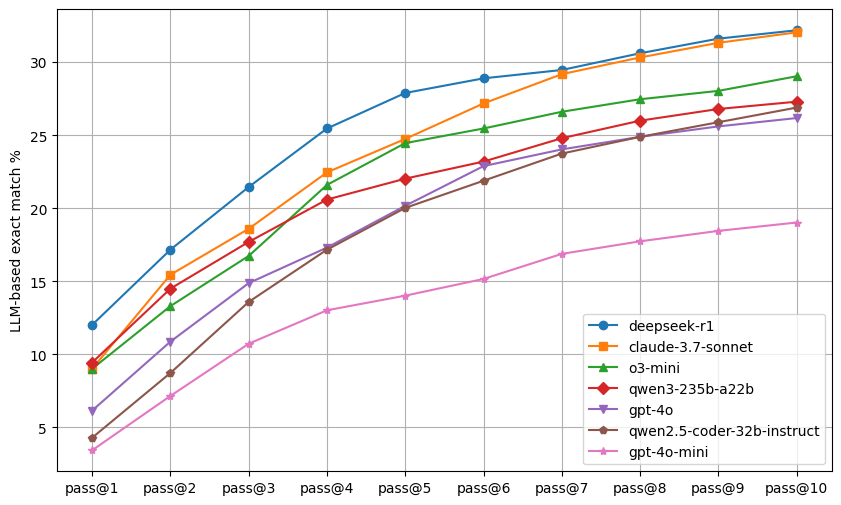

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import ast


models = ["deepseek-r1",
          "claude-3.7-sonnet",
          "o3-mini",
          "qwen3-235b-a22b",
          "gpt-4o",
          "qwen2.5-coder-32b-instruct",
          "gpt-4o-mini",
         ]

plt.figure(figsize=(10, 6))
plt.ylabel("LLM-based exact match %")
plt.grid(True)

x_labels = [f"pass@{i+1}" for i in range(10)]

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

markers = ['o', 's', '^', 'D', 'v', 'p', '*']

for idx, model in enumerate(models):
    res = pd.read_csv(model + ".csv")
    labels = list(res['llm_as_a_judge_labels'])

    for i in range(len(labels)):
        labels[i] = ast.literal_eval(labels[i])
        for j in range(10):
            labels[i][j] = max(labels[i][:j + 1])
    labels = np.array(labels)
    labels = labels.mean(0) * 100

    plt.plot(range(1, 11), labels, marker=markers[idx], label=model, color=colors[idx])

plt.xticks(range(1, 11), x_labels)
plt.legend()
plt.savefig("pass@k_progress.png", dpi=300, transparent=False, bbox_inches="tight")
plt.show()

In [5]:
def jsonl_to_dataframe(file_path):
    data = []

    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            json_object = json.loads(line.strip())
            data.append(json_object)

    df = pd.DataFrame(data)
    return df


topics_df = jsonl_to_dataframe("rucodereview_refine_topic.jsonl")

model_df_0 = pd.read_csv(models[0] + '.csv').set_index("Unnamed: 0")
model_df_1 = pd.read_csv(models[1] + '.csv').set_index("Unnamed: 0")

model_df_0['general_topic'] = topics_df['general_topic']
model_df_1['general_topic'] = topics_df['general_topic']

model_df_0['metrics_dict'] = model_df_0['metrics'].apply(lambda x: ast.literal_eval(x))
model_df_1['metrics_dict'] = model_df_1['metrics'].apply(lambda x: ast.literal_eval(x))

metrics_df_0 = pd.json_normalize(model_df_0['metrics_dict'])
metrics_df_1 = pd.json_normalize(model_df_1['metrics_dict'])

df_0 = pd.concat([model_df_0, metrics_df_0], axis=1)
df_1 = pd.concat([model_df_1, metrics_df_1], axis=1)

mean_metrics_by_topic_0 = df_0[list(metrics_df_0.columns) + ['general_topic']].groupby('general_topic').mean()
mean_metrics_by_topic_1 = df_1[list(metrics_df_1.columns) + ['general_topic']].groupby('general_topic').mean()

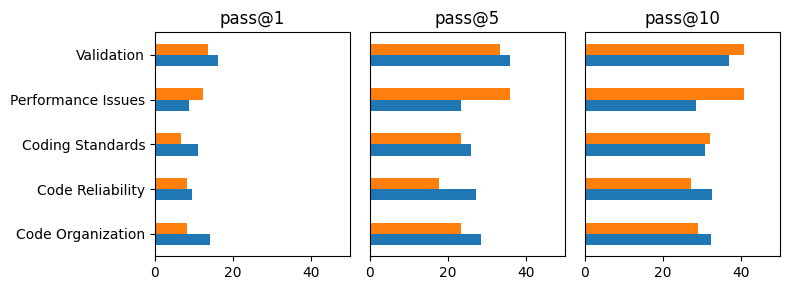

In [17]:
def get_combined_df(metric):
    mean_metrics_by_topic_0 = df_0[[metric] + ['general_topic']].groupby('general_topic').mean() * 100
    mean_metrics_by_topic_1 = df_1[[metric] + ['general_topic']].groupby('general_topic').mean() * 100

    mean_metrics_by_topic_0.columns = [f'deepseek-r1' for col in mean_metrics_by_topic_0.columns]
    mean_metrics_by_topic_1.columns = [f'claude-3.7-sonnet' for col in mean_metrics_by_topic_1.columns]

    return pd.concat([mean_metrics_by_topic_0, mean_metrics_by_topic_1], axis=1)

metrics = ['pass@1', 'pass@5', 'pass@10']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 3), sharex=True)

for i, (ax, metric) in enumerate(zip(axes, metrics)):
    combined_df = get_combined_df(metric)
    combined_df.plot(kind='barh', ax=ax, width=0.5)
    ax.set_title(metric)

    if i == 0:
        ax.set_xlim(0, 50)
        ax.tick_params(axis='y', rotation=0)
        ax.set_ylabel("")
        ax.get_legend().remove()
    else:
        ax.set_xlim(0, 50)
        ax.get_yaxis().set_visible(False)
        ax.get_legend().remove()

plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
plt.savefig("pass_comparison.png", dpi=300, transparent=False, bbox_inches="tight")
plt.show()

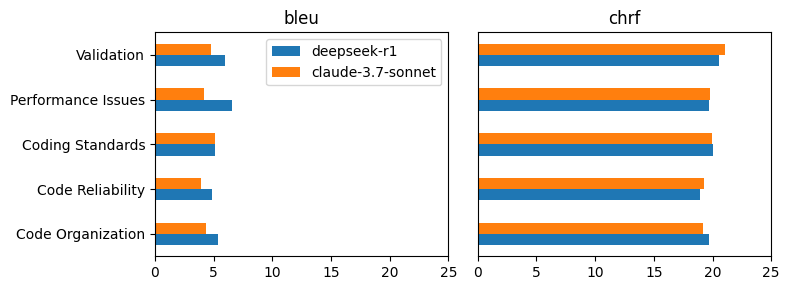

In [157]:
def get_combined_df(metric):
    mean_metrics_by_topic_0 = df_0[[metric] + ['general_topic']].groupby('general_topic').mean()
    mean_metrics_by_topic_1 = df_1[[metric] + ['general_topic']].groupby('general_topic').mean()

    mean_metrics_by_topic_0.columns = [f'deepseek-r1' for col in mean_metrics_by_topic_0.columns]
    mean_metrics_by_topic_1.columns = [f'claude-3.7-sonnet' for col in mean_metrics_by_topic_1.columns]

    return pd.concat([mean_metrics_by_topic_0, mean_metrics_by_topic_1], axis=1)

metrics = ['bleu', 'chrf']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3), sharex=True)

for i, (ax, metric) in enumerate(zip(axes, metrics)):
    combined_df = get_combined_df(metric)
    combined_df.plot(kind='barh', ax=ax, width=0.5)
    ax.set_title(metric)

    if i == 0:
        ax.set_xlim(0, 10)
        ax.tick_params(axis='y', rotation=0)
        ax.set_ylabel("")
    else:
        ax.set_xlim(0, 25)
        ax.get_yaxis().set_visible(False)
        ax.get_legend().remove()

plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
plt.savefig("bleu_chrf_comparison.png", dpi=300, transparent=False, bbox_inches="tight")
plt.show()